**GOALS**:
- Discover techniques to process imbalanced data.
- Explore data with more care.
- Start to develop metrics and function to evaluate and tune models.
- Feature selection (because treating all NaN adequately would take a long time -- 7xx features...)

**Table of contents**<a id='toc0_'></a>    
- 1. [Get some data](#toc1_)    
- 2. [Plotting individuals in the income/credit plan](#toc2_)    
- 3. [Addressing the class imbalance : under/oversampling & SMOTE](#toc3_)    
- 4. [LightGBM for feature importance](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [8]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import config
import colorcet as cc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
)
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler   
from imblearn.pipeline import Pipeline

from lightgbm import LGBMClassifier


# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Get some data

In [2]:
#Pick a number of individuals for faster results.
n_indiv = 5_000

In [3]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(config.FEATURE_PATH)

Data shape: (307506, 41), target shape: (307506,)


In [6]:
# down-sample
X = X.sample(n_indiv)
y = y.loc[X.index]

display(X.head())
display(y.head())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AGE_RANGE,CREDIT_TO_INCOME_RATIO,INCOME_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CREDIT_TO_ANNUITY_GROUP,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_INCOME_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_MEDIAN,GROUP2_ANNUITY_MEDIAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
342387,0,1,0,0,162000.0,942300.0,0,0,3,0,...,4,5.816406,-8.562500,0.130737,6,0.529785,144000.0,34.000000,900693.0,27760.5
366497,0,1,0,0,189000.0,942300.0,3,1,0,0,...,4,4.984375,-8.320312,0.200439,6,0.588867,157500.0,32.843750,814041.0,26086.5
310036,0,0,0,0,315000.0,791595.0,0,0,1,0,...,3,2.513672,-20.343750,0.240356,4,0.487549,135000.0,20.000000,450000.0,22018.5
224943,0,0,1,0,157500.0,450000.0,0,0,1,0,...,1,2.857422,-17.062500,0.204834,4,0.487549,135000.0,20.000000,450000.0,22018.5
345128,0,0,1,2,247500.0,509400.0,2,0,1,0,...,3,2.058594,-16.515625,0.278076,3,0.500488,157500.0,14.710938,397881.0,27193.5


SK_ID_CURR
342387    0.0
366497    0.0
310036    0.0
224943    0.0
345128    0.0
Name: TARGET, dtype: float16

In [7]:
# check imbalance mostly preserved
y.value_counts()

TARGET
0.0    4560
1.0     440
Name: count, dtype: int64

In [8]:
X_no_nan = X.dropna(axis=1)
X_no_nan.shape

(5000, 41)

Dropping all columns with nulls is losing a consequent part of information.
Imputation will probably be required for some models.

In [9]:
X_no_nan.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AGE_RANGE,CREDIT_TO_INCOME_RATIO,INCOME_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CREDIT_TO_ANNUITY_GROUP,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_INCOME_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_MEDIAN,GROUP2_ANNUITY_MEDIAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
342387,0,1,0,0,162000.0,942300.0,0,0,3,0,...,4,5.816406,-8.562500,0.130737,6,0.529785,144000.0,34.000000,900693.0,27760.5
366497,0,1,0,0,189000.0,942300.0,3,1,0,0,...,4,4.984375,-8.320312,0.200439,6,0.588867,157500.0,32.843750,814041.0,26086.5
310036,0,0,0,0,315000.0,791595.0,0,0,1,0,...,3,2.513672,-20.343750,0.240356,4,0.487549,135000.0,20.000000,450000.0,22018.5
224943,0,0,1,0,157500.0,450000.0,0,0,1,0,...,1,2.857422,-17.062500,0.204834,4,0.487549,135000.0,20.000000,450000.0,22018.5
345128,0,0,1,2,247500.0,509400.0,2,0,1,0,...,3,2.058594,-16.515625,0.278076,3,0.500488,157500.0,14.710938,397881.0,27193.5


In [10]:
y.head()

SK_ID_CURR
342387    0.0
366497    0.0
310036    0.0
224943    0.0
345128    0.0
Name: TARGET, dtype: float16

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Plotting individuals in the income/credit plan

In [11]:
def display_2d_with_illustrative_var(
    X,
    ax=None,
    figsize=(7,7),
    illustrative_var=None,
    alpha=0.7,
    palette=None,
    title=None,
):
    """ Display points in a plan with color for each class of illustrative var.

    X : dataframe with 2 cols (x, y)
    illustrative_var : list of length len(X) containing classes.
    """
    # Boolean which automates plt.show() if no ax is provided.
    final_plot = False
    if ax is None:
        fig, ax= plt.subplots(figsize=figsize)
        final_plot = True

    # Display the points
    if illustrative_var is None:
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=alpha)
    else:
        illustrative_var = np.array(illustrative_var)
        illustrative_values = np.unique(illustrative_var)
        n_val = len(illustrative_values)
        if palette is None:
            palette = sns.color_palette(cc.glasbey, n_val)
        # Plot reversely to see most frequent on top.
        for n, value in enumerate(illustrative_values):
            selected = np.where(illustrative_var == value)
            ax.scatter(
                X[selected, 0], X[selected, 1],
                alpha=alpha, label=value, color=palette[n_val - 1 - n],
                s=10
            )
        # ax.set_axis_off()
        if title is not None:
            ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1),
                    loc='upper left',
                    borderaxespad=0.,
                    fontsize=10)
        
        if final_plot:
            plt.show()
    return None

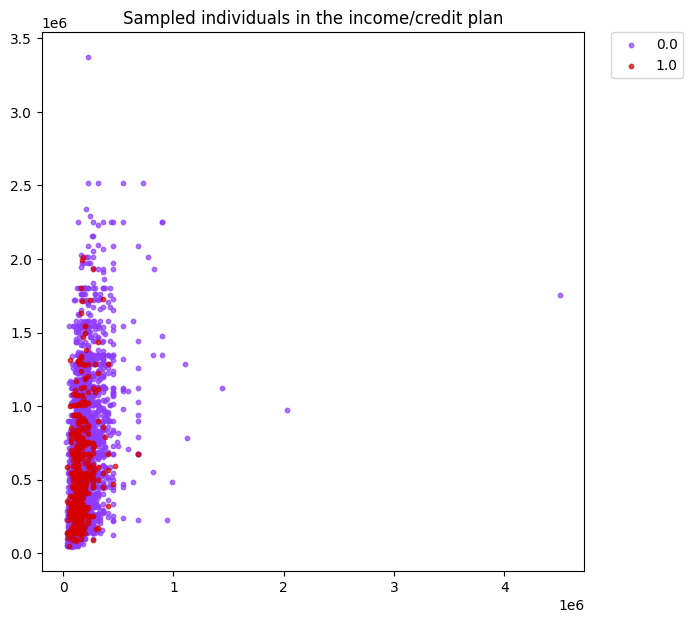

In [12]:
sel_fts = ['AMT_INCOME_TOTAL', 'AMT_CREDIT']
display_2d_with_illustrative_var(
    X_no_nan.loc[:, sel_fts].values,
    illustrative_var=y.values,
    title='Sampled individuals in the income/credit plan'
)



Although no visual difference strikes, it will help to illustrate the impact of imbalance class processing.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Addressing the class imbalance : under/oversampling & SMOTE

SMOTE main advantage : Help decreasing over-fitting while introducing synthetic individuals with some kind of interpolation .

Sources :
- [to understand SMOTE algorithm](https://kobia.fr/imbalanced-data-smote/)
- [some examples and tips](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

 It is pointed out that the original paper on SMOTE suggests combining SMOTE with random undersampling of the majority class.

Important things:
- SMOTE must not be applied on encoded categorical variables (which we have)
- SMOTE must not be applied on test and validation set (Evaluation would be unrealistic)
- SMOTE works better after feature normalization (because based on distances)
- SMOTE need hyperparameter tuning (because synthetic individuals can be wrongly introduced depending on the minority distribution)
- if SMOTE is applied on discrete features, the algorithm will introduce new intermediate values that must then be mapped to the original values.

Conclusion :

It will be interesting to apply that in the final model, but it needs to be done carefully and it will take some time. I'd rather start with a simple under/oversampling of classes first, run some models to assess feature importance and, then only prepare those features to be SMOTE-processed.

In [23]:
# create some minority synthetic individuals to yield a rate indicated in sampling_strategy
over = SMOTE(k_neighbors=5, sampling_strategy=0.4)
# downsample the majority class to something more balanced
under = RandomUnderSampler(sampling_strategy=0.7)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_resample, y_resample = pipeline.fit_resample(X_no_nan, y)

In [18]:
X_resample.shape

(4429, 41)

In [22]:
# Resample percentages
y_resample.value_counts()* 100/len(y_resample)

TARGET
0.0    58.816889
1.0    41.183111
Name: count, dtype: float64

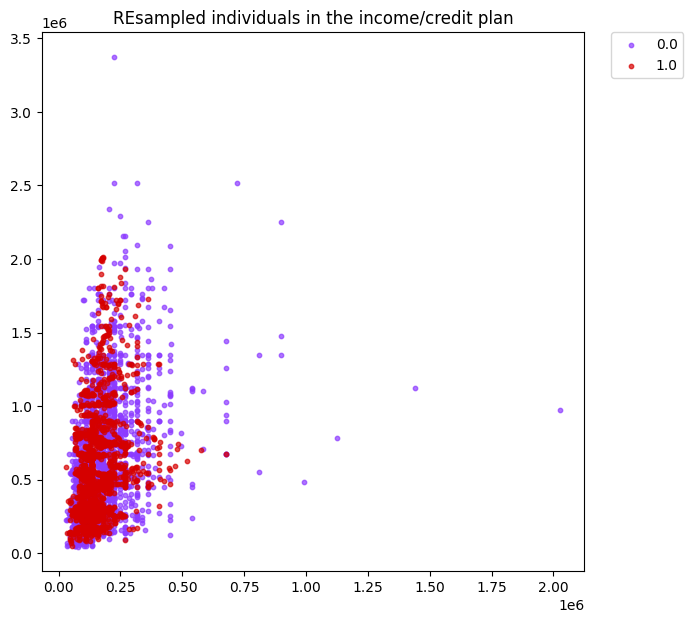

In [20]:
display_2d_with_illustrative_var(
    X_resample.loc[:, sel_fts].values,
    illustrative_var=y_resample.values,
    title='REsampled individuals in the income/credit plan'
)

We yield a much more balanced dataset and synthetic individuals looks natural in that plan. We have a bit less individuals in total but the percentage of the minority class is now closer to 50%. The proportions chosen when up or down sampling certain class will help the classification algorithm to detect properly the minority class. I will have to tune it alongside with the number of neighbors used by SMOTE.

Note that categorical features can be processed with SMOTE-NC

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Feature selection

A wide variety of feature selection algorithm exist.
- univariate statistic between each input and the output.
- evaluation of correlation between inputs (to avoid colinearity problems)
- intrinsic selection (some models such as lasso, or decision trees naturally perform feature selection).

Here, is a table showing how to compute statistics between variable types.


<img src="../notebook_images/statistics_table.png" width=600 />

## Intrinsic : With LightGBM feature importance

It is the model used in the kernel I used for feature extraction. Thus, features are already well prepared to go inside the model. And It can handle missing values with internal mechanism.

A note from the [documentation](https://lightgbm.readthedocs.io/en/stable/Python-Intro.html):
- LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).
Note: You should convert your categorical features to int type before you construct Dataset.


In [9]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(config.FEATURE_PATH, drop_INF=False, drop_NAN=False)

Data shape: (307506, 735), target shape: (307506,)


In [10]:
# Merge, split in train/test sets, extract targets.
# I will CV on the set so no need for a validation set
data = X.merge(y, on='SK_ID_CURR')
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
    random_state=config.RANDOM_SEED,
    stratify=data.TARGET
)

y_train = train_df.pop('TARGET')
y_test = test_df.pop('TARGET')

print(
    f"Train shapes : {train_df.shape}, {y_train.shape}\n"
    + f"Test shapes : {test_df.shape}, {y_test.shape}"
)

Train shapes : (246004, 735), (246004,)
Test shapes : (61502, 735), (61502,)


In [14]:
# Check stratified splits work correctly
def class_percentages(target):
    display(target.value_counts() * 100 / len(target))
    return None

for y_ in ['y_train', 'y_test']:
    print(f'In the {y_.removeprefix("y_")} set:')
    class_percentages(eval(y_))
    

In the train set:


TARGET
0.0    91.927367
1.0     8.072633
Name: count, dtype: float64

In the test set:


TARGET
0.0    91.927092
1.0     8.072908
Name: count, dtype: float64

In [18]:
# define LightGBM configuration
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 30,
    'max_depth': 10,
    # 'subsample_for_bin': 240000,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.5,
    # 'min_split_gain': 0.02,
    'subsample': 1,
    # 'is_unbalance': True, <-- no need if taken care with sampling
    # 'silent':1,
    # 'verbose':1
}

# List categorical features for LightGBM partitioning mechanism (Fisher 1958)
categorical_feature = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START'
]


clf = LGBMClassifier(**LIGHTGBM_PARAMS)


In [16]:
# Define imblearn pipeline to be used on the training folds of the CV
# without SMOTE because it would be to much of a chore on 7xx features
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
resample_pipe = Pipeline(steps=steps)

In [ ]:
# An example of a custom metric close to the one I'd like
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [21]:
# Define folds
folds = StratifiedKFold(
    n_splits=config.NUM_FOLDS,
    shuffle=True,
    random_state=config.RANDOM_SEED
)

# Array to receive, per split, prediction of the validation set (out of fold).
oof_preds = np.zeros(train_df.shape[0])
# Some other variables to hold results.
sub_preds = np.zeros(test_df.shape[0])
importance_df = pd.DataFrame()
auc_df = dict()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_train)):
    print(f"\n\n##############################\n split {n_fold + 1}")
    train_x, train_y = train_df.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = train_df.iloc[valid_idx], y_train.iloc[valid_idx]
    print("end making folds")
    
    # Resample the train set and check the balance
    train_x_resample, train_y_resample = resample_pipe.fit_resample(train_x, train_y)
    print("\n Class percentage in the training folds")
    class_percentages(train_y_resample)
    print("\n Class percentage in the validation fold")
    class_percentages(valid_y)
    
    # Fit the classifier on the resample training set.
    clf.fit(
        train_x_resample, train_y_resample,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc',
        early_stopping_rounds=300,
        categorical_feature=categorical_feature
    )

    best_iter = clf.best_iteration_
    # Partially filling oof_preds
    oof_preds[valid_idx] = clf.predict_proba(
        valid_x,
        num_iteration=best_iter
    )[:, 1]
    # Progressively compute the mean prediction on the test set
    sub_preds += clf.predict_proba(
        test_df,
        num_iteration=best_iter
    )[:, 1] / folds.n_splits

    # Feature importance by GAIN and SPLIT
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = train_df.columns
    fold_importance["gain"] = (
        clf.booster_.feature_importance(importance_type='gain')
    )
    fold_importance["split"] = (
        clf.booster_.feature_importance(importance_type='split')
    )
    importance_df = pd.concat([importance_df, fold_importance], axis=0)
    
    # Save metric value for each iteration in train and validation sets
    auc_df['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
    auc_df['valid_{}'.format(n_fold + 1)] = clf.evals_result_['valid_1']['auc']

    print(
        'Fold %2d AUC : %.4f'
        % (
            n_fold + 1,
            roc_auc_score(valid_y, oof_preds[valid_idx])
        )
    )
    
    del clf, train_x, train_y, valid_x, valid_y
    gc.collect()

#End CV loop

print('Full AUC score %.6f' % roc_auc_score(y_train, oof_preds))
test_df['TARGET'] = sub_preds.copy()

# Get the average feature importance between folds
mean_importance = importance_df.groupby('feature').mean().reset_index()
mean_importance.sort_values(by='gain', ascending=False, inplace=True)
# Save feature importance, test predictions and oof predictions as csv
# if config.GENERATE_SUBMISSION_FILES:
#     # Generate oof csv
#     oof = pd.DataFrame()
#     oof['SK_ID_CURR'] = df['SK_ID_CURR'].copy()
#     oof['PREDICTIONS'] = oof_preds.copy()
#     oof['TARGET'] = df['TARGET'].copy()
#     file_name = 'oof{}.csv'.format(config.SUBMISSION_SUFIX)
#     oof.to_csv(os.path.join(config.SUBMISSION_DIRECTORY, file_name), index=False)

#     # Submission and feature importance csv
#     sub_path = os.path.join(config.SUBMISSION_DIRECTORY,'submission{}.csv'.format(config.SUBMISSION_SUFIX))
#     test[['SK_ID_CURR', 'TARGET']].to_csv(sub_path, index=False)
#     imp_path = os.path.join(config.SUBMISSION_DIRECTORY,'feature_importance{}.csv'.format(config.SUBMISSION_SUFIX))
#     mean_importance.to_csv(imp_path, index=False)




##############################
 split 1
end making folds

 Class percentage in the training folds


TARGET
0.0    55.555446
1.0    44.444554
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.926993
1.0     8.073007
Name: count, dtype: float64

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:

 
X = X .fillna(0)

lr = LogisticRegression() 
lr = lr.fit(X, y)
proba = lr.predict_proba(X)

print(proba[:100])    